<a href="https://colab.research.google.com/github/shashankbhagat/Multilabel-Image-Classification/blob/master/Multi_Label_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q '/content/drive/My Drive/Datsets/Multi_label_image_classification/Images.zip'

In [0]:
#do not execute
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import re
import pickle
import multiprocessing as mp
import threading as th
%matplotlib inline

In [5]:
trained_model_exists=False
try:
    f=open('/content/drive/My Drive/Datsets/Multi_label_image_classification/trained_model.bkp','rb')
    trained_model_exists=True
except:
    trained_model_exists=False

print(trained_model_exists)

True


In [0]:
#do not execute
#Download csv from Google Drive
csv_link='https://drive.google.com/open?id=1fHX_qjo6zMZZyLHVLpdxtYnG528tU_U4'
temp, csv_id=csv_link.split('=')
downloaded=drive.CreateFile({'id':csv_id})
downloaded.GetContentFile('train.csv')


In [6]:
train=pd.read_csv('/content/drive/My Drive/Datsets/Multi_label_image_classification/train.csv')
train.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [7]:
train.columns

Index(['Id', 'Genre', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'N/A', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [0]:
#do not execute
#Download images from google drive
pattern=re.compile('[a-zA-Z0-9]+[.]jpg')
local_img_path=os.path.expanduser(os.getcwd()+'/Images')
try:
    os.makedirs(local_img_path)
except: pass

print(local_img_path)
img_folder_link='https://drive.google.com/open?id=1zoWXcDzfjxeYbvOknbGU5WyM707yDGcP'
temp,img_folder_id=img_folder_link.split('=')
print(img_folder_id)
#downloaded=drive.CreateFile({'id':img_folder_id})
#downloaded.GetContentFile('Images')
fileList=drive.ListFile({'q':"'{}' in parents".format(str(img_folder_id))}).GetList()
for f in tqdm(fileList):
    #print(f['title'])
    if bool(re.match(pattern,f['title'])):
        try:
            fname=os.path.join(local_img_path,f['title'])
            downloaded=drive.CreateFile({'id':f['id']})
            downloaded.GetContentFile(fname)
        except: pass

/content/Images
1zoWXcDzfjxeYbvOknbGU5WyM707yDGcP


100%|██████████| 7876/7876 [1:00:24<00:00,  2.37it/s]


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#do not execute
import re
pattern=re.compile('[a-zA-Z0-9]+[.]jpg')
print(bool(re.match(pattern,'23sdf3dsfds45.jpg')))

True


In [0]:
train_image=[]
def load_data(start,end,pos):
    print('in load data:',start,end)
    #i=i[0]
    temp=[]
    for i in range(start,end+1):
        img=image.load_img('/content/drive/My Drive/Datsets/Multi_label_image_classification/Images/'+train['Id'][i]+'.jpg',target_size=(400,400,3))
        img=image.img_to_array(img)
        img=img/255
        temp.append(img)
    with open('/content/drive/My Drive/Datsets/Multi_label_image_classification/train_image_'+str(pos)+'.bkp','wb') as f:
        pickle.dump(temp,f)
    #train_image.append(temp)
    

In [9]:
#preprocessing the data
print(train.shape)
X=[]
try:
    with open('/content/drive/My Drive/Datsets/Multi_label_image_classification/trainX.bkp',rb) as f:
        X=pickle.load(f)
except: pass
pool=mp.Pool(4)
print('X:',X)
args_list=[]
threads_list=[]
if len(X)==0:
    start=0
    end= -1   #train.shape[0]//4
    a=[]
    for i in range(4):   #cpu_count
        start=end+1    
        end=start+(train.shape[0]//4)
        if i==3:
            end=train.shape[0]-1
        temp_arg=[start,end]
        args_list.append(temp_arg)
print(args_list)
    

(7254, 27)
X: []
[[0, 1813], [1814, 3627], [3628, 5441], [5442, 7253]]


In [10]:
backup_exists=False
for i in range(len(args_list)):
    try:
        f=open('/content/drive/My Drive/Datsets/Multi_label_image_classification/train_image_'+str(i)+'.bkp','rb')
        backup_exists=True
    except:
        backup_exists=False
        break

print(backup_exists)

True


In [0]:
if len(X)==0 and backup_exists==False:
    for i,val in tqdm(enumerate(args_list)):
        print('i:',i,val)        
        #th_temp=th.Thread(target=load_data,args=(val[0],val[1],i),)
        #threads_list.append(th_temp)
        load_data(val[0],val[1],i)

    #for th in threads_list:
    #    th.start()

    #for th in threads_list:
    #    th.join()
    
    #train_image=pool.map(load_data,(val for val in args_list))

    #pool.close()
    #pool.join()
    #train_image=[r.get() for r in result_objects]
    print('done parallel...')
    

In [0]:
#do not execute
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('/content/Images/'+train['Id'][i]+'.jpg',target_size=(400,400,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

#X=np.array(train_image)

100%|██████████| 7254/7254 [00:48<00:00, 149.76it/s]


In [0]:
#do not execute
with open('/content/drive/My Drive/Datsets/Multi_label_image_classification/trainX.bkp','wb') as f:
    pickle.dump(X,f)

In [12]:
#create the Y
y=np.array(train.drop(['Id','Genre'],axis=1))
print(y.shape)

(7254, 25)


In [13]:
#setup the model
if not trained_model_exists:
    model=Sequential()
    model.add(Conv2D(filters=16,kernel_size=(5,5),activation='relu',input_shape=(400,400,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=32,kernel_size=(5,5),activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25,activation='sigmoid'))
else:
    with open('/content/drive/My Drive/Datsets/Multi_label_image_classification/trained_model.bkp','rb') as f:
        temp=pickle.Unpickler(f)
        model=temp.load()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 396, 396, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 198, 198, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 198, 198, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 194, 194, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 97, 97, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 93, 93, 64)       

In [0]:
if not trained_model_exists:
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
X=[]
if not trained_model_exists:
    for i,val in enumerate(args_list):
        with open('/content/drive/My Drive/Datsets/Multi_label_image_classification/train_image_'+str(i)+'.bkp','rb') as f:
            train_image=pickle.load(f)
            X=np.array(train_image)
            y_temp=y[val[0]:val[1]+1]
            X_train,X_test,y_train,y_test=train_test_split(X,y_temp,random_state=42,test_size=0.1)
    #X=[]
            model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=64)

    with open('/content/drive/My Drive/Datsets/Multi_label_image_classification/trained_model.bkp','wb') as f:
        pickle.dump(model,f)

Drama (0.428)
Action (0.271)
Thriller (0.228)


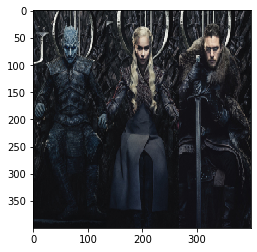

In [21]:
#testing the model for GOT
img=image.load_img('/content/drive/My Drive/Datsets/Multi_label_image_classification/Test/GOT.jpg',target_size=(400,400,3))
img=image.img_to_array(img)
img=img/255
classes=np.array(train.columns[2:])
prob=model.predict(img.reshape(1,400,400,3))
top_3=np.argsort(prob[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(prob[0][top_3[i]]))
plt.imshow(img)

Drama (0.434)
Action (0.264)
Thriller (0.208)


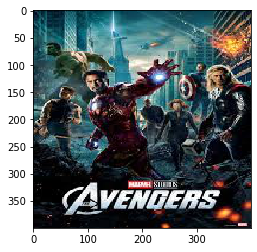

In [22]:
#testing the model for Avenger
img=image.load_img('/content/drive/My Drive/Datsets/Multi_label_image_classification/Test/avengers.jpeg',target_size=(400,400,3))
img=image.img_to_array(img)
img=img/255
classes=np.array(train.columns[2:])
prob=model.predict(img.reshape(1,400,400,3))
top_3=np.argsort(prob[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(prob[0][top_3[i]]))
plt.imshow(img)